In [1]:
import sys
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap
from mne.time_frequency import psd_welch
from preprocess import process_eegs
from scipy.stats import ttest_ind
from teja_vae_cpd import teja_vae_cpd
import mne
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import TensorFox as tfx
import torch
import torch.nn as nn

In [2]:
full_psds, _, _, _, _, grade, epi_dx, alz_dx, _, _, _, _, raw_eegs = process_eegs(return_raw= True)
an_eegs = raw_eegs[(epi_dx<0) & (alz_dx<0)]
pop_psds= full_psds[(epi_dx<0) & (alz_dx<0)]
psds_min = torch.min(pop_psds)
psds_max = torch.max(pop_psds)

trans_psds = (pop_psds - psds_min)/(psds_max - psds_min)

In [3]:
ch_names = ['fp1', 'f3', 'f7', 'c3', 't7', 'p3', 'p7', 'o1', 
            'fp2', 'f4', 'f8', 'c4', 't8', 'p4', 'p8', 'o2',
            'fz', 'cz', 'pz']
ch_names = [ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp') for ch_name in ch_names]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=256)
info.set_montage('standard_1020')

def plot_factors(factors, d=3, factors_name=["Epochs", "Topomap", "Spectrum"]):

    rank = factors[0].shape[1]
    
    # sns.reset_orig()
    fig, all_axs = plt.subplots(rank, d, figsize=(12, int(rank * 2 + 1)))
    
    for ind, (factor, axs) in enumerate(zip(factors[:d], all_axs.T)):
        # axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            if ind == 0:
                sns.kdeplot(data=f, ax=ax)
            if ind == 1:
                mne.viz.plot_topomap(f, info, sensors=False, contours=0, cmap=cm.viridis, show=False, axes=ax)
            if ind == 2:
                sns.despine(top=True, ax=ax)
                ax.plot(f)
                ax.set_xlabel("Frequency (Hz)")
            all_axs[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    plt.show()

In [4]:
model = torch.load("../checkpoints/teja_vae_cp_supervised_original_rank_6.pth") 
model.eval()
model.to("cpu")
trans_psds = trans_psds.to(torch.float32)
epoch_components, _, _ = model.encoder(trans_psds)
epoch_components = epoch_components.detach().cpu()
spatial_components = model.decoder.other_mus[0].detach().cpu()
frequency_components = model.decoder.other_mus[1].detach().cpu()

factors = [epoch_components, spatial_components, frequency_components]
tfx.change_sign(factors)
print()

In [5]:
min_indices = [] 
max_indices = []
for i in range(epoch_components.shape[1]):
    min_indices.append(torch.argmin(epoch_components[:,i]).item())
    max_indices.append(torch.argmax(epoch_components[:,i]).item())
print(min_indices)
print(max_indices)

[12416, 12673, 12416, 12673, 586, 1793]
[12673, 12416, 12673, 12416, 10642, 12416]


In [6]:
# eeg_tensor = an_eegs[min_indices[5]]
# eeg_array = eeg_tensor#.numpy()
# num_channels = eeg_array.shape[0]
# fig, axs = plt.subplots(num_channels, 1, figsize=(10, 3*num_channels))
# for i in range(num_channels):
#     axs[i].plot(eeg_array[i, :])
#     axs[i].set_title('Channel {}'.format(ch_names[i]))
#     axs[i].set_xlabel('Time (samples)')
#     axs[i].set_ylabel('Amplitude')
# plt.tight_layout()
# plt.show()

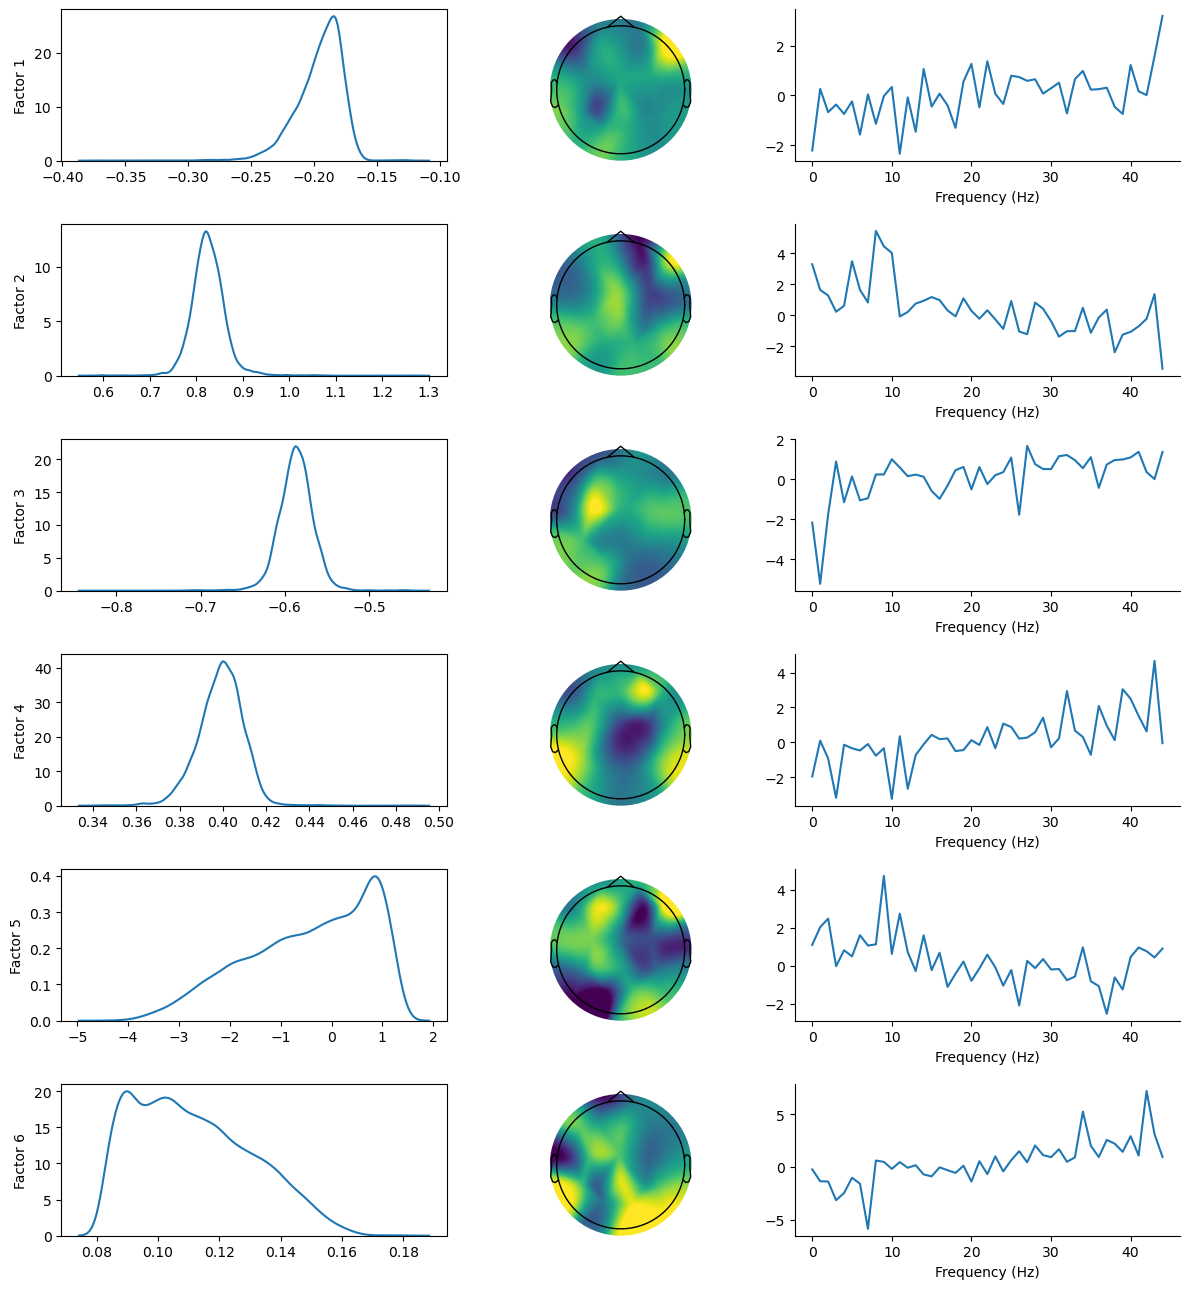

In [7]:
plot_factors(factors)

In [8]:
# _, _, _, _, _, grade, epi_dx, alz_dx, _, _, _, _ = process_eegs()

abnormal_vs_normal = grade[(epi_dx<0) & (alz_dx<0)]
print(abnormal_vs_normal.shape)

torch.Size([14052])


p-value for Factor 1: 0.0


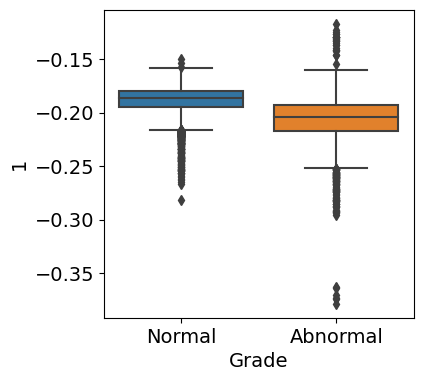

p-value for Factor 2: 0.5132111059394631


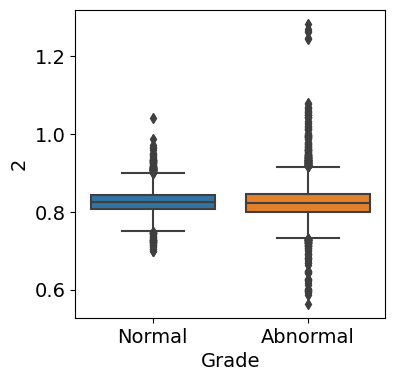

p-value for Factor 3: 2.6702657380253644e-22


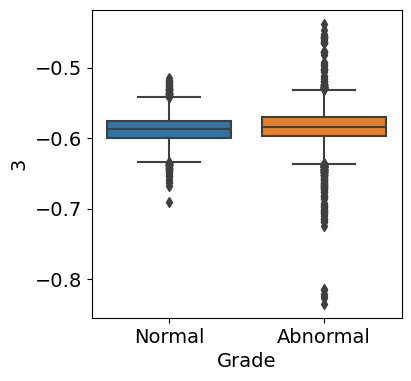

p-value for Factor 4: 0.0


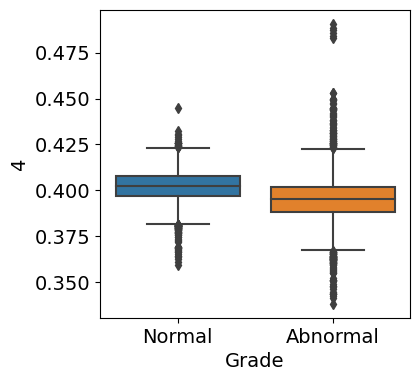

p-value for Factor 5: 0.0


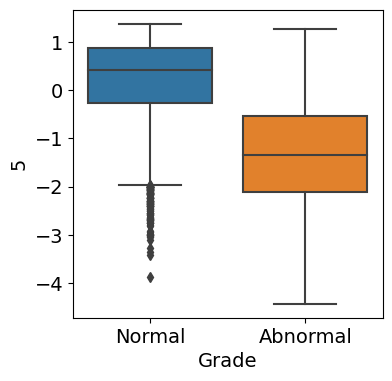

p-value for Factor 6: 0.0


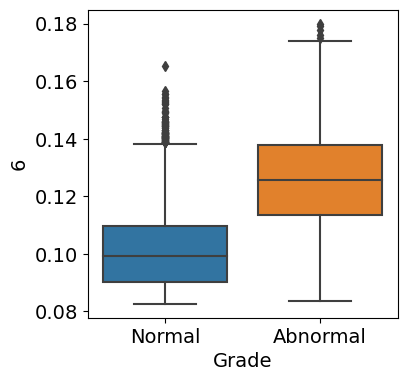

In [9]:
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 14
rank = epoch_components.shape[1]
for i in range(rank):
    fig, ax = plt.subplots(1,1)
    x = np.array(abnormal_vs_normal[abnormal_vs_normal>=0])
    y = np.array(torch.flatten(epoch_components[:,i])[abnormal_vs_normal>=0])
    
    abnormal = torch.flatten(epoch_components[:,i])[abnormal_vs_normal == 1]
    normal = torch.flatten(epoch_components[:,i])[abnormal_vs_normal == 0]
    t_test = ttest_ind(abnormal, normal)
    print(f"p-value for Factor {i+1}: {t_test.pvalue}")
    sns.boxplot(x=x, y=y, ax=ax)

    plt.xticks(np.arange(2), ['Normal', 'Abnormal'])

    ax.set_xlabel("Grade", {'fontsize' : 14})
    ax.set_ylabel(i+1, {'fontsize' : 14})
    plt.show()